In [27]:
from __future__ import division, print_function
import os

import collections
import csv
import datetime
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# from sklearn.metrics import root_mean_squared_error
import pickle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


ph = 6
history = 6
input_size = 2

# os.makedirs('./processed_data/eighty_twenty', exist_ok=True)

folder_dir = './model_checkpoints_split_only_cgm'

model_save_name = 'training_split_80_20_{ph}_{history}_{input_size}.pkl'.format(ph=ph, history=history, input_size=input_size)

results_save_name = 'results_split_80_20_{ph}_{history}_{input_size}.csv'.format(ph=ph, history=history, input_size=input_size)

model_save_path = os.path.join(folder_dir, model_save_name)
results_save_path = os.path.join(folder_dir, results_save_name)

In [28]:
# Load processed data
training_filename = "./processed_data/BIG_training_data_onlyCGM.pkl"


In [29]:
def prepare_dataset(segments, ph, history, input_size):
    '''
    ph = 6, 30 minutes ahead
    ph = 12, 60 minutes ahead
    '''
    features_list = []
    labels_list = []
    raw_glu_list = []
    
    # Iterate over each segment
    for segment_name, segment_df in segments.items():
        # Ensure all columns are of numeric type
        if input_size == 4: 
            segment_df['carb_effect'] = pd.to_numeric(segment_df['carb_effect'], errors='coerce')
            segment_df['steps'] = pd.to_numeric(segment_df['steps'], errors='coerce')
            segment_df['steps'] = segment_df['steps'] 
            
        segment_df['bolus_effect'] = pd.to_numeric(segment_df['bolus_effect'], errors='coerce')

        # Fill NaNs that might have been introduced by conversion errors
        segment_df.fillna(0, inplace=True)

        # Maximum index for creating a complete feature set
        max_index = len(segment_df) - (history-1+ph+1)  # Subtracting 22 because we need to predict index + 21 and need index + history-1 to exist
        
        # Iterate through the data to create feature-label pairs
        for i in range(max_index + 1):
            # Extracting features from index i to i+history-1
            if input_size == 4:
                features = segment_df.loc[i:i+history-1, ['glucose_value',  'bolus_effect', 'carb_effect', 'steps']] 
            else: 
                features = segment_df.loc[i:i+history-1, ['glucose_value',  'bolus_effect']]
            
            label = segment_df.loc[i+history-1+ph, 'glucose_value'] - segment_df.loc[i+history-1, 'glucose_value']
            
            raw_glu_list.append(segment_df.loc[i+history-1+ph, 'glucose_value'])
            features_list.append(features)
            labels_list.append(label)
            
    print("len of features_list " + str(len(features_list)))
    print("len of labels_list " + str(len(labels_list)))
    # new_labels_list = label_delta_transform(labels_list)    
    # print("after label transform. the len of label list "+str(len(new_labels_list)))    
    return features_list, labels_list, raw_glu_list

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim


class StackedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(StackedLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True).to(device)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob).to(device)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True).to(device)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 512).to(device)
        self.fc2 = nn.Linear(512, 128).to(device)
        self.fc3 = nn.Linear(128, output_size).to(device)
        
        # Activation functions
        self.relu = nn.ReLU()
        
    
    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size from the input tensor

        # Initialize hidden and cell state for the first LSTM layer
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        
        # First LSTM layer
        out, (hn, cn) = self.lstm1(x, (h0, c0))
        
        # Dropout layer
        out = self.dropout(out)
        
        # Initialize hidden and cell state for the second LSTM layer
        h1 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c1 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        
        # Second LSTM layer
        out, (hn, cn) = self.lstm2(out, (h1, c1))
        
        # Fully connected layers
        out = out[:, -1, :]  # Get the last time step output
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out


In [31]:

# Load the dictionary from the file
with open(training_filename, 'rb') as f:
    loaded_df_dict = pickle.load(f)

print(loaded_df_dict['1segment_1'])
print(loaded_df_dict['1segment_2'])

step_updated_segments = loaded_df_dict


             timestamp  glucose_value  bolus_effect
0  2021-12-07 16:30:00            101          0.58
1  2021-12-07 16:35:00            100          0.51
2  2021-12-07 16:40:00            100          0.44
3  2021-12-07 16:45:00             99          0.37
4  2021-12-07 16:50:00             98          0.30
..                 ...            ...           ...
65 2021-12-07 21:55:00            144          1.13
66 2021-12-07 22:00:00            140          1.06
67 2021-12-07 22:05:00            139          0.99
68 2021-12-07 22:10:00            140          0.92
69 2021-12-07 22:15:00            140          0.70

[70 rows x 3 columns]
               timestamp  glucose_value  bolus_effect
0    2021-12-07 22:35:00            139          0.57
1    2021-12-07 22:40:00            143          0.50
2    2021-12-07 22:45:00            138          0.43
3    2021-12-07 22:50:00            133          0.36
4    2021-12-07 22:55:00            132          0.29
...                  ...     

In [32]:
# Prepare for training
features_list, labels_list, raw_glu_list = prepare_dataset(step_updated_segments, ph, history, input_size) # segments, ph, history

# Build training and validation loader
features_array = np.array(features_list)
labels_array = np.array(raw_glu_list) # Maybe need to replace this

X_train, X_val, y_train, y_val = train_test_split(features_array, labels_array, test_size=0.2, shuffle= False)

print("Prediction horizon: ", ph)
print("History: ", history)

len of features_list 67203
len of labels_list 67203
Prediction horizon:  6
History:  6


In [33]:
# Data Preparation (assuming X_train, y_train, X_val, y_val are numpy arrays)
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False) # The original batch size = 128, however, training on 128 cannot get the model fully trained, so change to 32.
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [34]:
input_size = input_size # Number of input features
hidden_size = 128  # Hidden vector size
num_layers = 2  # Number of LSTM layers
output_size = 1  # Single output
dropout_prob = 0.2  # Dropout probability

model = StackedLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob) # input_size, hidden_size, num_layers, output_size, dropout_prob
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [35]:
num_epochs =100
for epoch in range(num_epochs):
    model.train()
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}')


    model.eval()
    with torch.no_grad():
        total_loss = 0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.float())
            total_loss += loss.item()
        
        avg_loss = total_loss / len(val_loader)
        print(f'Test Loss: {avg_loss:.4f}')



c:\Users\Biratal\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Biratal\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Training Loss: 134.3486


c:\Users\Biratal\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 2014.1555
Epoch [2/100], Training Loss: 117.9757
Test Loss: 1896.3290
Epoch [3/100], Training Loss: 54.0525
Test Loss: 1881.3503
Epoch [4/100], Training Loss: 154.1521
Test Loss: 1870.2190
Epoch [5/100], Training Loss: 53.6664
Test Loss: 1855.7162
Epoch [6/100], Training Loss: 121.5450
Test Loss: 1851.7477
Epoch [7/100], Training Loss: 99.6642
Test Loss: 1841.9724
Epoch [8/100], Training Loss: 135.6564
Test Loss: 1845.2561
Epoch [9/100], Training Loss: 129.8951
Test Loss: 1837.5949
Epoch [10/100], Training Loss: 148.2572
Test Loss: 1829.6864
Epoch [11/100], Training Loss: 142.0764
Test Loss: 1835.7650
Epoch [12/100], Training Loss: 115.9562
Test Loss: 1832.7204
Epoch [13/100], Training Loss: 102.8841
Test Loss: 1836.2281
Epoch [14/100], Training Loss: 94.4279
Test Loss: 1831.8500
Epoch [15/100], Training Loss: 81.1271
Test Loss: 1834.0389
Epoch [16/100], Training Loss: 121.0718
Test Loss: 1831.7652
Epoch [17/100], Training Loss: 164.2698
Test Loss: 1832.9070
Epoch [18/100], 

In [37]:
# # # save the model 
torch.save(model.state_dict(), model_save_path)

In [38]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs)
        actuals.append(targets)

predictions = torch.cat(predictions).cpu().numpy()
actuals = torch.cat(actuals).cpu().numpy()


rmse = mean_squared_error(actuals,predictions)
print(f'RMSE on validation set: {np.sqrt(rmse)}')

RMSE on validation set: 29.156940460205078


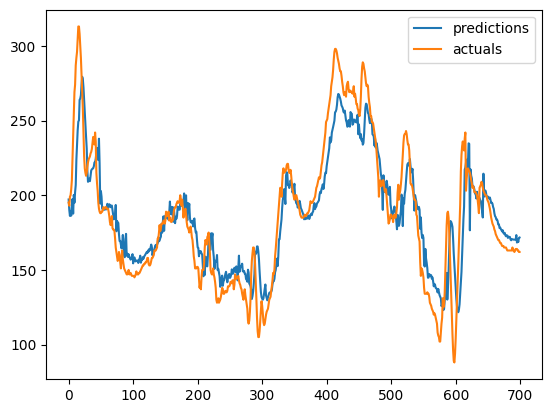

In [39]:
plt.plot(predictions[:700], label = 'predictions')
plt.plot(actuals[:700], label = 'actuals')
plt.legend()

# Testing

In [40]:
def test_model(model, test_step_updated_segments, ph, history, input_size):

    # Prepare for training
    features_list_test, labels_list_test, raw_glu_list_test = prepare_dataset(test_step_updated_segments, ph, history, input_size) # segments, ph, history, input_size
    
    # Build training and validation loader
    features_array_test = np.array(features_list_test)
    labels_array_test = np.array(raw_glu_list_test) # Maybe need to replace this

    X_test, y_test = features_array_test, labels_array_test

    # Data Preparation (assuming X_train, y_train, X_val, y_val are numpy arrays)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.append(outputs)
            actuals.append(targets)

    predictions = torch.cat(predictions).cpu().numpy()
    actuals = torch.cat(actuals).cpu().numpy()

    rmse = np.sqrt(mean_squared_error(actuals,predictions))
    print(f'RMSE on validation set: {rmse}')
    
    return predictions, actuals, rmse

In [25]:
# If loading a model 
model_dir = './model_checkpoints_split_only_cgm/stacked_lstm_model_cgm_only_6_6.pth'
folder_dir = './model_checkpoints_split_only_cgm'

input_size = 2
hidden_size = 128
num_layers = 2
output_size = 1
dropout_prob = 0.2
ph = 6
history = 6

model = StackedLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob)
model.load_state_dict(torch.load(model_dir))

results_save_name = 'results_split_80_20_{ph}_{history}_{input_size}.csv'.format(ph=ph, history=history, input_size=input_size)
results_save_path = os.path.join(folder_dir, results_save_name)


In [41]:
import glob

preds = []
trues = []
errors = []
fname = []

for file in glob.glob("./processed_data/*test*nk.pkl"):
    test_filename = file
    with open(test_filename, 'rb') as f:
        test_loaded_df_dict = pickle.load(f)

    # Verify the content
    test_step_updated_segments = test_loaded_df_dict
    pred, true, rmse = test_model(model, test_step_updated_segments, ph, history, input_size)
    preds.append(pred)
    trues.append(true)
    errors.append(rmse)
    fname.append(file.split('\\')[-1].split('_')[0])


len of features_list 2393
len of labels_list 2393
RMSE on validation set: 27.193445205688477
len of features_list 2537
len of labels_list 2537
RMSE on validation set: 21.668155670166016
len of features_list 2635
len of labels_list 2635
RMSE on validation set: 24.624839782714844
len of features_list 2480
len of labels_list 2480
RMSE on validation set: 29.474979400634766
len of features_list 2758
len of labels_list 2758
RMSE on validation set: 22.268001556396484
len of features_list 2716
len of labels_list 2716
RMSE on validation set: 27.126564025878906


In [42]:
np.mean(errors)

25.392664

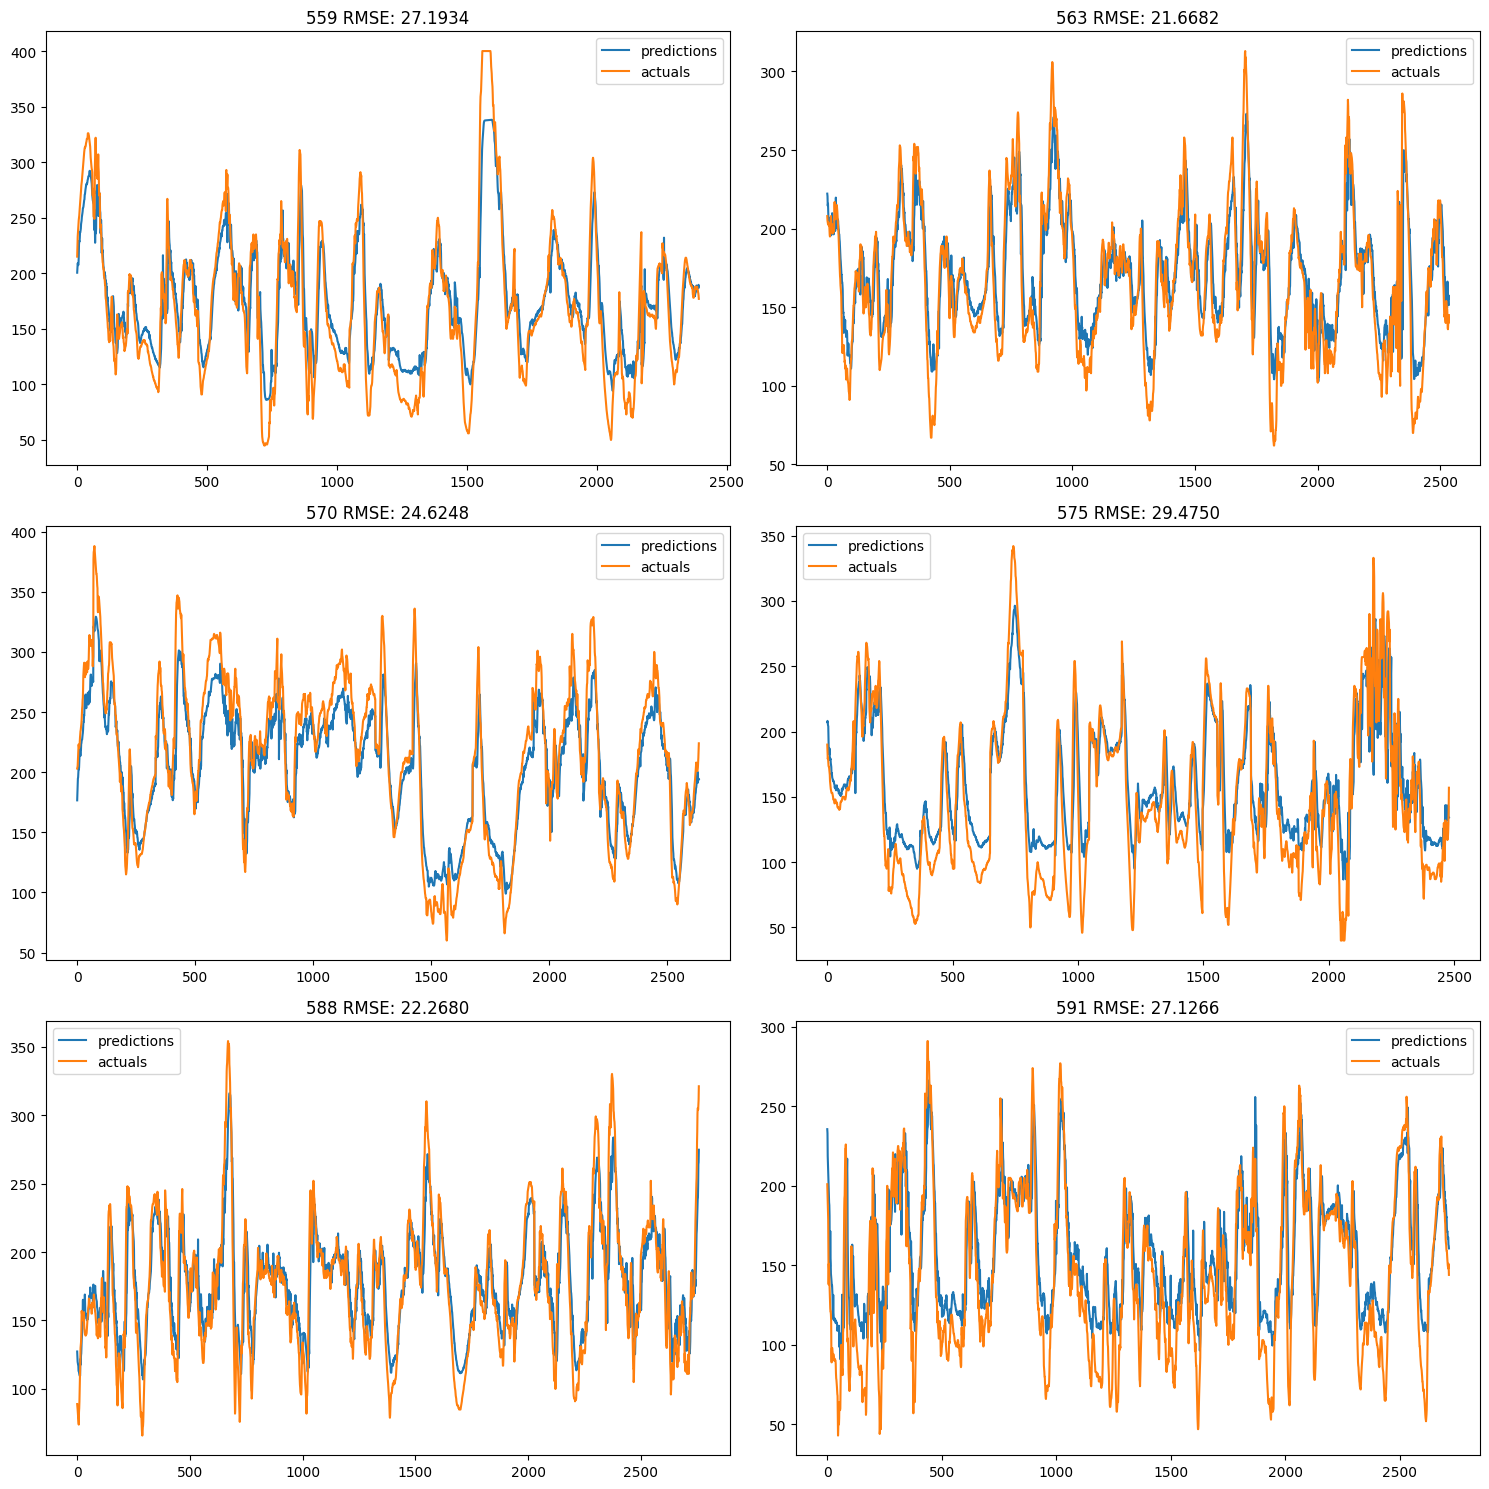

In [43]:
# make a 3x 2 plot and plot the preds and actuals of each one in each and have the title be the filename and the rmse

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

for i in range(3):
    for j in range(2):
        idx = i*2 + j
        axs[i, j].plot(preds[idx], label = 'predictions')
        axs[i, j].plot(trues[idx], label = 'actuals')
        axs[i, j].legend()
        axs[i, j].set_title(f'{fname[idx]} RMSE: {errors[idx]:.4f}')
        
plt.tight_layout()

In [44]:
# convert this all to a table 
# save the table as a csv
# convert the fname and the rmse to a dataframe
curr_dat = pd.DataFrame({'fname': fname, 'rmse': errors})


In [46]:
import numpy as np
import pandas as pd

# Assuming curr_dat is your DataFrame and errors is a list of RMSE values

errors = curr_dat['rmse'].tolist()

# Calculate the average RMSE
average_rmse = np.mean(errors)

# Create a DataFrame for the average row
average_row = pd.DataFrame({'fname': ['average'], 'rmse': [average_rmse]})

# Concatenate the original DataFrame with the average row
curr_dat_with_average = pd.concat([curr_dat, average_row], ignore_index=True)

curr_dat_with_average.to_csv(results_save_path, index=False)

In [47]:
curr_dat_with_average

,fname,rmse
0,559,27.193445
1,563,21.668156
2,570,24.624840
3,575,29.474979
4,588,22.268002
5,591,27.126564
6,average,25.392664


In [45]:
print(results_save_path)

./model_checkpoints_split_only_cgm\results_split_80_20_6_6_2.csv
